# Multi-Output Symbolic Regression

Demonstrates `MultiOutputSymbolicRegressor` for discovering separate algebraic
expressions for multiple target columns simultaneously.

In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from jaxsr import (
    BasisLibrary,
    MultiOutputSymbolicRegressor,
    SymbolicRegressor,
    cross_validate,
)

## Generate synthetic multi-output data

Two inputs $(x_0, x_1)$ and two outputs:

$$y_0 = 3\,x_0 - 1.5\,x_1^2 + 2$$
$$y_1 = x_0\,x_1 + 0.5\,x_0^2$$

In [2]:
np.random.seed(42)
n_samples = 150
X = np.random.randn(n_samples, 2) * 1.5

y0 = 3.0 * X[:, 0] - 1.5 * X[:, 1] ** 2 + 2.0
y1 = X[:, 0] * X[:, 1] + 0.5 * X[:, 0] ** 2

# Add small noise
y0 += np.random.randn(n_samples) * 0.1
y1 += np.random.randn(n_samples) * 0.1

Y = np.column_stack([y0, y1])

X_jax = jnp.array(X)
Y_jax = jnp.array(Y)

print(f"Data shape: X={X_jax.shape}, Y={Y_jax.shape}")
print("True models:")
print("  y0 = 3*x0 - 1.5*x1^2 + 2")
print("  y1 = x0*x1 + 0.5*x0^2")

Data shape: X=(150, 2), Y=(150, 2)
True models:
  y0 = 3*x0 - 1.5*x1^2 + 2
  y1 = x0*x1 + 0.5*x0^2


## Build a basis library and fit

In [3]:
library = (
    BasisLibrary(n_features=2, feature_names=["x0", "x1"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
    .add_interactions(max_order=2)
)

template = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="greedy_forward",
    information_criterion="bic",
)

mo = MultiOutputSymbolicRegressor(
    estimator=template,
    target_names=["force", "energy"],
)
mo.fit(X_jax, Y_jax)

print(f"Number of outputs: {mo.n_outputs_}")
for name, expr in zip(mo.target_names_, mo.expressions_, strict=False):
    print(f"  {name}: {expr}")
print(f"\nMean R^2: {mo.score(X_jax, Y_jax):.6f}")

Number of outputs: 2
  force: y = - 1.503*x1^2 + 3.003*x0 + 2.012
  energy: y = 0.995*x0*x1 + 0.4985*x0^2

Mean R^2: 0.999192


## Parity plots for each output

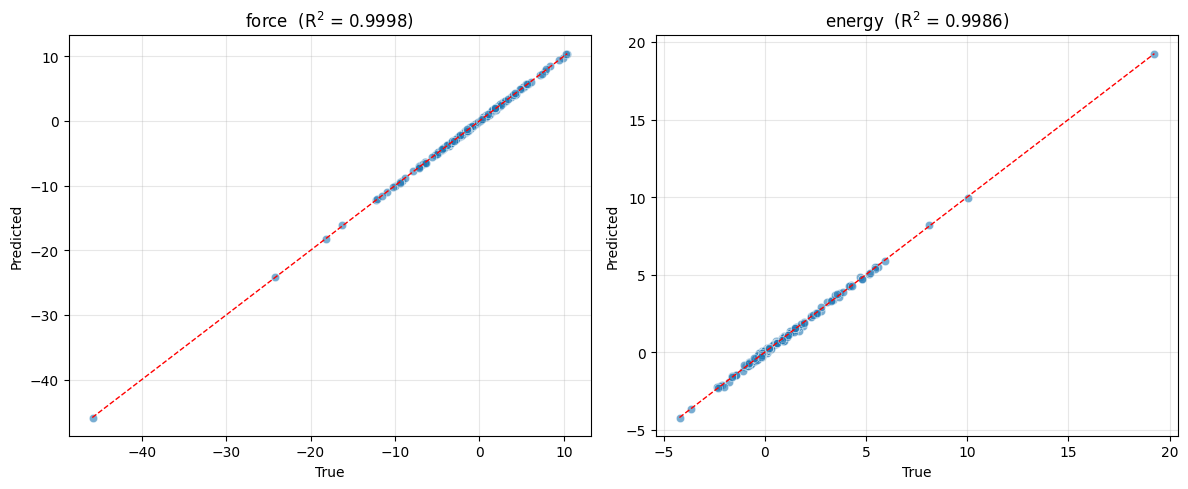

In [4]:
Y_pred = mo.predict(X_jax)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for j, name in enumerate(mo.target_names_):
    ax = axes[j]
    y_true_j = np.array(Y_jax[:, j])
    y_pred_j = np.array(Y_pred[:, j])
    ax.scatter(y_true_j, y_pred_j, alpha=0.6, edgecolors="white", linewidth=0.5)
    lims = [min(y_true_j.min(), y_pred_j.min()), max(y_true_j.max(), y_pred_j.max())]
    ax.plot(lims, lims, "r--", linewidth=1)
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    r2 = mo.estimators_[j].score(X_jax, Y_jax[:, j])
    ax.set_title(f"{name}  (R$^2$ = {r2:.4f})")
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Per-output model details

In [5]:
print(mo.summary())

--- Output: force ---
JAXSR Symbolic Regression Model

Expression: y = - 1.503*x1^2 + 3.003*x0 + 2.012

Selected terms (3):
  x1^2: -1.50281
  x0: 3.00253
  1: 2.01194

Metrics:
  MSE: 0.00884672
  R²: 0.999788
  BIC: -268.44
  AIC: -277.47
  Complexity: 3

Training samples: 150
Strategy: greedy_forward

--- Output: energy ---
JAXSR Symbolic Regression Model

Expression: y = 0.995*x0*x1 + 0.4985*x0^2

Selected terms (2):
  x0*x1: 0.99498
  x0^2: 0.498458

Metrics:
  MSE: 0.00931707
  R²: 0.998596
  BIC: -265.68
  AIC: -271.70
  Complexity: 4

Training samples: 150
Strategy: greedy_forward



## Export to LaTeX and pure NumPy callable

In [6]:
# LaTeX
for name, latex in zip(mo.target_names_, mo.to_latex(), strict=False):
    print(f"{name}: ${latex}$")

# Pure NumPy callable (no JAX dependency needed)
predict_fn = mo.to_callable()
X_test = np.array([[1.0, 2.0], [0.5, -1.0]])
print(f"\nNumPy predictions for X = {X_test.tolist()}:")
print(predict_fn(X_test))

force: $3.00252723693848 x_{0} - 1.50280845165253 x_{1}^{2.0} + 2.01193857192993$
energy: $0.994980096817017 x_{0} x_{1} + 0.498458415269852 x_{0}^{2.0}$

NumPy predictions for X = [[1.0, 2.0], [0.5, -1.0]]:
[[-0.996768    2.48841861]
 [ 2.01039374 -0.37287544]]


## Cross-validation

In [7]:
cv_results = cross_validate(mo, X_jax, Y_jax, cv=5, scoring="neg_mse")
print(f"5-fold CV neg-MSE: {cv_results['mean_test_score']:.4f} +/- {cv_results['std_test_score']:.4f}")
print(f"Per-fold scores: {np.round(cv_results['test_scores'], 4)}")

5-fold CV neg-MSE: -0.0094 +/- 0.0016
Per-fold scores: [-0.0094 -0.0098 -0.0093 -0.0117 -0.0068]


## Save / load round-trip

In [8]:
import os

mo.save("multi_output_model.json")
loaded = MultiOutputSymbolicRegressor.load("multi_output_model.json")

Y_loaded = loaded.predict(X_jax)
max_diff = float(jnp.max(jnp.abs(Y_pred - Y_loaded)))
print(f"Max prediction difference after round-trip: {max_diff:.2e}")
print(f"Loaded target names: {loaded.target_names_}")
for name, expr in zip(loaded.target_names_, loaded.expressions_, strict=False):
    print(f"  {name}: {expr}")

os.remove("multi_output_model.json")

Max prediction difference after round-trip: 0.00e+00
Loaded target names: ['force', 'energy']
  force: y = - 1.503*x1^2 + 3.003*x0 + 2.012
  energy: y = 0.995*x0*x1 + 0.4985*x0^2
